In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
from plotly.subplots import make_subplots
import plotly.express as px
from numpy import mean

# Problem statement

According to the World Health Organisation (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
Our goal is to build a ML model that is able to predict whether a patient is likely to get a stroke based on input parameters like gender, age, various diseases and lifestyle.

# Exploratory data analysis

We have some basic assumptions about what are some causes for a higher probabiliy of getting stroke, which are based on our general knowledge as well as doing some light browsing on the internet. Here are some well-known factors:
* Hypertension (high blood pressure
) or other hearth issues 
* Cholesterol which builds up plaque in arteries
* Diabetes
* Unhealthy lifestyle like: smoking, lack of physical activity, alcohol or drug comsumption, high stress levels
* Genetics


In [2]:
# Load the data
df = pd.read_csv("data/stroke_data.csv")
df

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

In [3]:
print(df.dtypes)

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


**Note:** Within the explorations, we will try different plotting libraries: plotly, seaborn and matplotlib. This is intentional with the goal to play around with different visualisation options.

##  Basic understanding of data

In [4]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

Some interesting findings so far from looking at the DF: 
* the id column is not useful for us and we will drop it
* the age seems evenly distributed across all age levels
* both hypertension and heart_disease are categorical boolean features (already translated into 0 and 1 values), and we already see that they are both highly imbalanced with majority value 0
* we will most likely see some outliers in the avg_glucose_level and bmi
* bmi contains some NaNs
* there are some clear outliers in the BMI, as a value of 97 is very very very high
* the target variable stroke is also highly imbalanced, with majority value 0
* in general, we will deal with a lot of categorical features in this dataset. Only age, avg_glucose_level and bmi are numerical (continuous) variable

In [5]:
df.isna().sum().sort_values(ascending=False)

bmi                  201
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64

This dataset is very clean, with only BMI having NaN values. We want to avoid dropping rows to make sure we have the biggest dataset possible, so we will replace the NaN values with some kind of average in the 'Feature engineering and selection part'. 

## Correlation between numeric variables

We will check the correlation coeffs for the numeric values first

In [6]:
df.corr()

/var/folders/1_/qh2gt0m949d5_hzcd4src0vw0000gn/T/ipykernel_93228/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


id       age  hypertension  heart_disease  \
id                 1.000000  0.003538      0.003550      -0.001296   
age                0.003538  1.000000      0.276398       0.263796   
hypertension       0.003550  0.276398      1.000000       0.108306   
heart_disease     -0.001296  0.263796      0.108306       1.000000   
avg_glucose_level  0.001092  0.238171      0.174474       0.161857   
bmi                0.003084  0.333398      0.167811       0.041357   
stroke             0.006388  0.245257      0.127904       0.134914   

                   avg_glucose_level       bmi    stroke  
id                          0.001092  0.003084  0.006388  
age                         0.238171  0.333398  0.245257  
hypertension                0.174474  0.167811  0.127904  
heart_disease               0.161857  0.041357  0.134914  
avg_glucose_level           1.000000  0.175502  0.131945  
bmi                         0.175502  1.000000  0.042374  
stroke                      0.131945  0.042374  1.000000

/var/folders/1_/qh2gt0m949d5_hzcd4src0vw0000gn/T/ipykernel_93228/2522350660.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


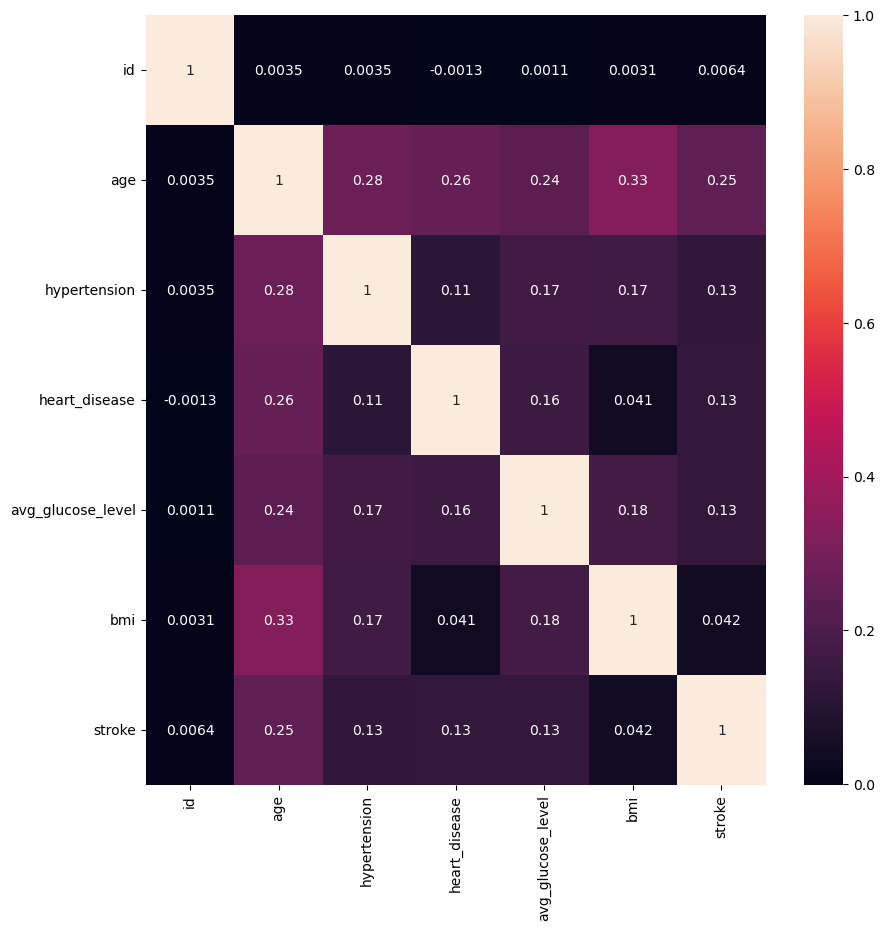

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

We can see that some features are clearly correlated with having stroke or not - hypertension and other heart disease, high avg. glucose levels and age. There is also a high correlation between age and all the other variables, and also noticing specifically bmi, which seems to not be directly correlated with stroke despite our assumption, but is very highly correlated with age. 
This overall correlation with age is in line with the assumption that the older the person is, the higher likelihood of these diseases.

## Stroke(target)

*Assumption:* As with these kind of diseases, usually the sample is imbalanced with majority consisting of people with no stroke.

<Axes: xlabel='count', ylabel='stroke'>

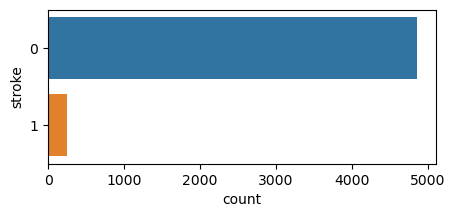

In [8]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.countplot(y=df.stroke, ax=ax)

*Summary of findings:*
In our sample, stroke occurs for around 4.9% of the observations.
This is a highly imbalanced dataset. We will have to use certain balancing techniques to make the prediction for stroke == 1 more accurate.

## Gender

*Assumption:* Gender plays a role in stroke. Males are more likely to get stroke than women.

In [9]:
px.histogram(df, y="gender", color = "stroke", template = "seaborn", title = "Gender and stroke", width=600, height=300, histnorm="percent")

In [10]:
df[df.gender == 'Other']

id gender   age  hypertension  heart_disease ever_married work_type  \
3116  56156  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0

*Summary of findings:*
Gender doesn't seem to have an impact on the fact if a person has stroke or not.
There is only 1 observation in the category 'Other' with stroke == 0, so I will drop this row during the feature engineering to reduce dimensionality.

## Age

*Assumption:* Age plays a role in getting stroke. The older the person, the more likely they are to get stroke.

<Axes: xlabel='age', ylabel='Density'>

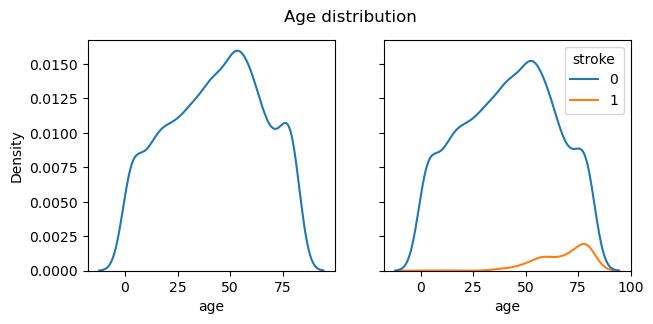

In [11]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(7, 3))
fig.suptitle ("Age distribution")
sns.kdeplot(ax=axes[0], data=df, x="age")
sns.kdeplot(ax=axes[1], data=df, x="age", hue="stroke")

*Summary of findings:*
The age distribution of this sample is from babies to elderly age groups. The most dominant group is between 40-60 years. We don't know where the sample is from, but in general our assumption is that it represents a population in developing nations, with another peak around 80 years of age.

The age distribution from the stroke perspective is very different fom people with stroke and without. 
For people with stroke, the peak is at a higher age around 80.

## Heart related issues - heart disease and hypertension

*Assumption:* Heart diseases and hypertension is a factor in developing stroke. People with one of these conditions are more likely to get stroke.

In [12]:

px.histogram(df,y="hypertension", template="seaborn",title = "Hypertension", width = 700, height=300, histnorm="percent")


In [13]:
fig = px.pie(df, names="stroke", facet_col="hypertension", template="seaborn", title = "Hypertension and stroke", width=800, height=400)
fig.show()

Only 10% of the overall number of observations have hypertension.
From those with hypertension, this % is more than 3 times higher than for those without stroke.

In [14]:
px.histogram(df,y="heart_disease", template="seaborn",title = "Hypertension", width = 700, height=300, histnorm="percent")


In [15]:
fig = px.pie(df, names="stroke", facet_col="heart_disease", template="seaborn", title = "Heart disease and stroke", width=800, height=400)
fig.show()

Only 5.4% of the overall number of observations have heart disease.
From those with heart disease, this % is 4 times higher than for those without stroke.

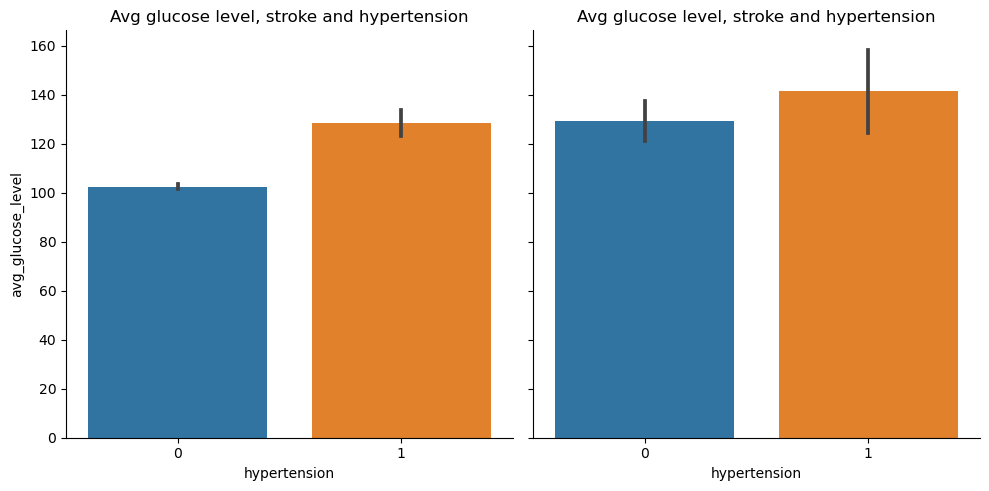

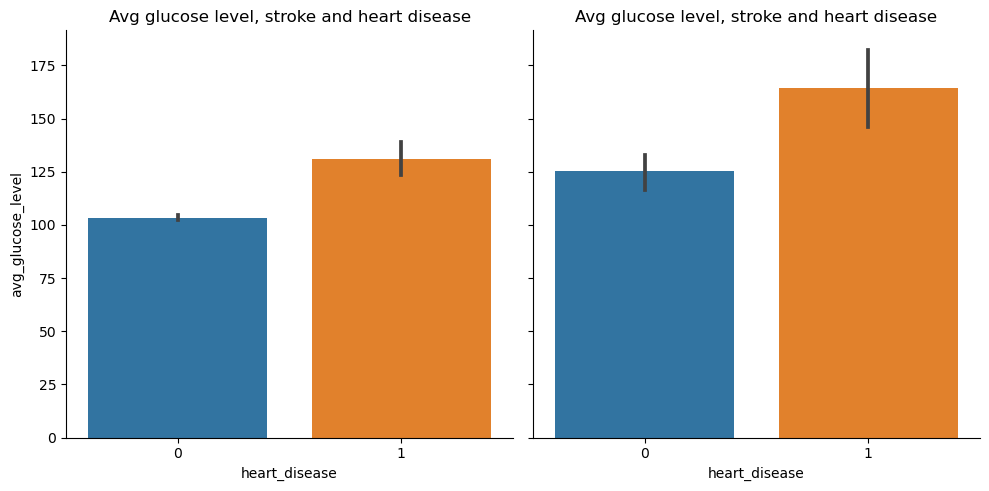

In [16]:
sns.catplot(data=df, x="hypertension", y="avg_glucose_level", col="stroke",
    kind="bar").set(title="Avg glucose level, stroke and hypertension")

sns.catplot(data=df, x="heart_disease", y="avg_glucose_level", col="stroke",
    kind="bar").set(title="Avg glucose level, stroke and heart disease")

A higher value of glucose level indicates hypertension or heart disease or stroke, and highest when a combination of heart related issue and stroke is present with the mean glucose level being the highest in case of a heart disease and stroke. 

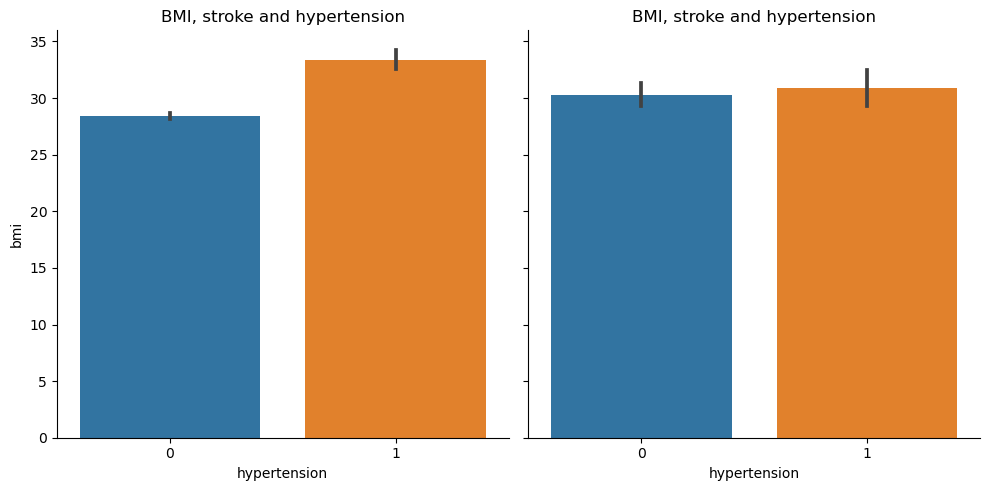

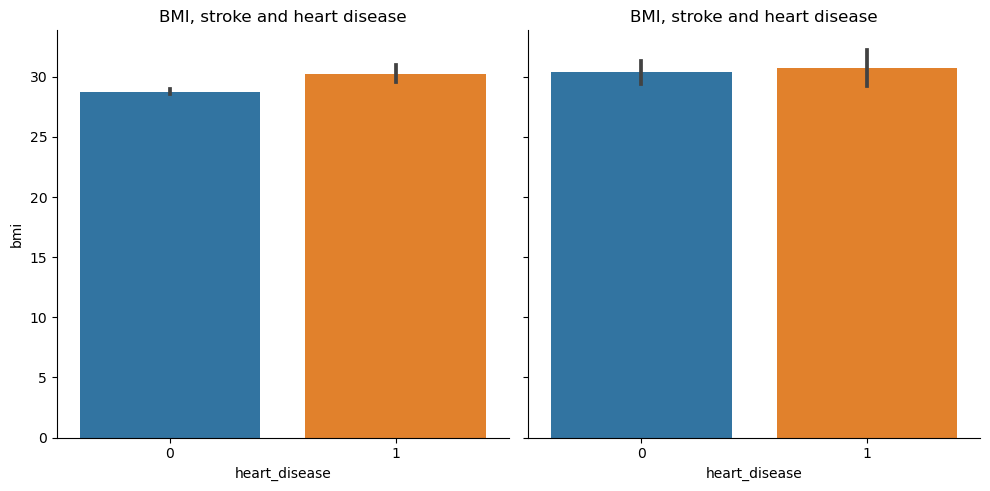

In [17]:
sns.catplot(data=df, x="hypertension", y="bmi", col = "stroke",
    kind="bar").set(title="BMI, stroke and hypertension")

sns.catplot(data=df, x="heart_disease", y="bmi", col = "stroke",
    kind="bar").set(title="BMI, stroke and heart disease")

We don't see any similar significant relationship for the bmi.

## Marriage

*Assumption:* Marriage contributes to more stressful life and therefore can be a factor in getting stroke. 

In [18]:
px.histogram(df,y="ever_married", template="seaborn", title = "Married or not married", width = 700, height=300, histnorm="percent")


In [19]:
fig = px.pie(df, names="stroke", facet_col="ever_married", template="seaborn", title = "Ever married and stroke", width=800, height=400)
fig.show()

There are twice as many ever married people in our observation than never married.
In our overall sample set, 66 % are people who have ever been married.
4x higher percentage of people who have ever been married had stroke compared to those who have never been married (6.6% vs 1.6 %)

In [20]:
px.histogram(df,y="gender", color="ever_married", template="seaborn", barnorm='percent', title = "Married and gender (% normalized)",  width = 600, height=300)

The proportion people who have been married vs. not married is the same of males and females,
63% for male and 66% for females.

## Work and living

*Assumption:* Self-employed people, people working in private sector and residing in urban environments have higher levels of stress and so higher probability of developing stroke.

In [21]:
px.histogram(df,y="work_type", template="seaborn", title="Work type (%)", width=700, height=300, histnorm="percent")


In [22]:
fig = px.pie(df, names="stroke", facet_col="work_type", template="seaborn", title="Work type and stroke", width=800, height=400)
fig.show()

*Summary of findings:*
Most of people in the sample are employed in the private sector (57%). 
Logically, almost none of the children segment had stroke. 
On the other hand, the % of self-employed with stroke is higher than the other types of work. We don't see the same for private-sector workers. 

In [23]:
px.histogram(df,y="Residence_type", template="seaborn", title = "Residence type (%)", width = 600, height=300, histnorm="percent")


In [24]:
fig = px.pie(df, names="stroke", facet_col="Residence_type", template="seaborn", title="Residence type and stroke", width=800, height=400)
fig.show()

*Summary of findings:*
The distribution of rural and urban dwellers in our sample is the same. The % of urban dwellers with stroke is slightly higher than for the segment with no stroke.

## Smoking

*Assumption:* Smoking is a factor in developing stroke. Men are more likely to smoke than women.

In [25]:
px.histogram(df,y="smoking_status", template="seaborn", title = "Smoking status (%)", width = 600, height=300, histnorm="percent")


*Summary of findings:*
37% of the sample has never smoked. 
33% of the sample smokes or has formerly smoked, which is quite a large %. 
30% of the sample hasn't answered this question - this is quite a large %, we are however not able to answer why nor are we able to replace the value base with the status based on other variables.

In [26]:
px.histogram(df,y="gender", color="smoking_status", template="seaborn", barnorm='percent', title = "Married and gender (% normalized)",  width = 600, height=300)

*Summary of findings:* There is a larger % of females who have never smoked (41% femals vs 31% males). A Higher % of males hasn't specified if they smoke or not (33% females to 27% males). Taking together the group of people who have smoked or smoke now, men have a higher %.

In [27]:
fig = px.pie(df, names="stroke", facet_col="smoking_status", template="seaborn", title="Smoking status and stroke", width=800, height=400)
fig.show()

[Text(0.5, 1.0, 'Smoking, age and stroke')]

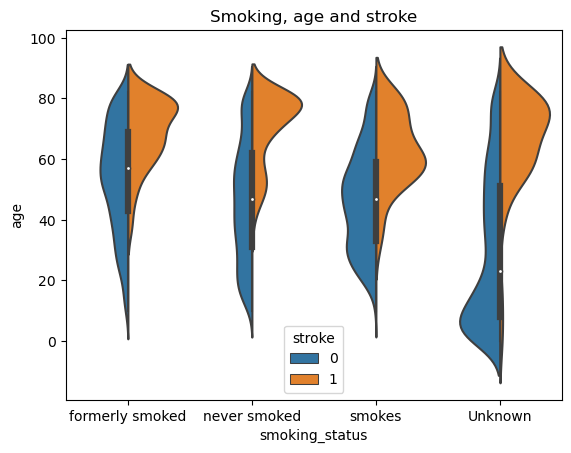

In [28]:
sns.violinplot(x ='smoking_status', y ='age', data = df, hue ='stroke', split = True).set(title="Smoking, age and stroke")

*Summary of findings:*
For those whohe have formerly smoked, but already stopped, the % of having stroke is the highest. My assumption is that deteriorating health might be a factor in their decision to stop smoking. Interestingly, people who currently smoke have a similar % of people with stroke as those who have never smoked and had stroke. However, when looking at the age distribution, for those who have never smoked, the mean age is much higher than for those who smoke.

## Other health indicators - BMI and glucose level

*Assumption:* Higher BMI and glucose levels are factors in developing stroke.

97.6

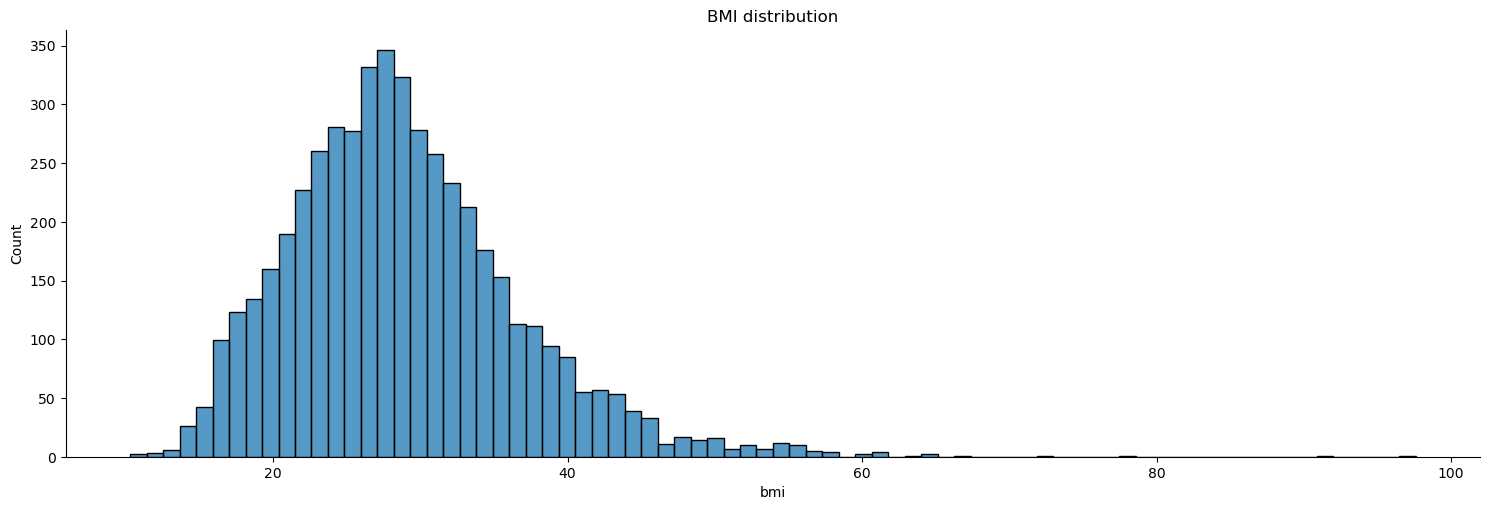

In [29]:
sns.displot(data=df, x="bmi", height = 5, aspect = 15/5).set(title="BMI distribution")
max(df.bmi)

*Summary of findings:*
The distribution of BMI seems to be in line with the bmi distributions I found in the internet.  The generally accepted levels:
*  `<`18 underweight
* 18-25 normal
* 25-30 overweight
*  `>`30 obese -  very very very obese

We also see that the distribution is slightly skewed to the right. Due to this when doing feature engineering, we will replace the NA values of BMI with the median (and not the mean).

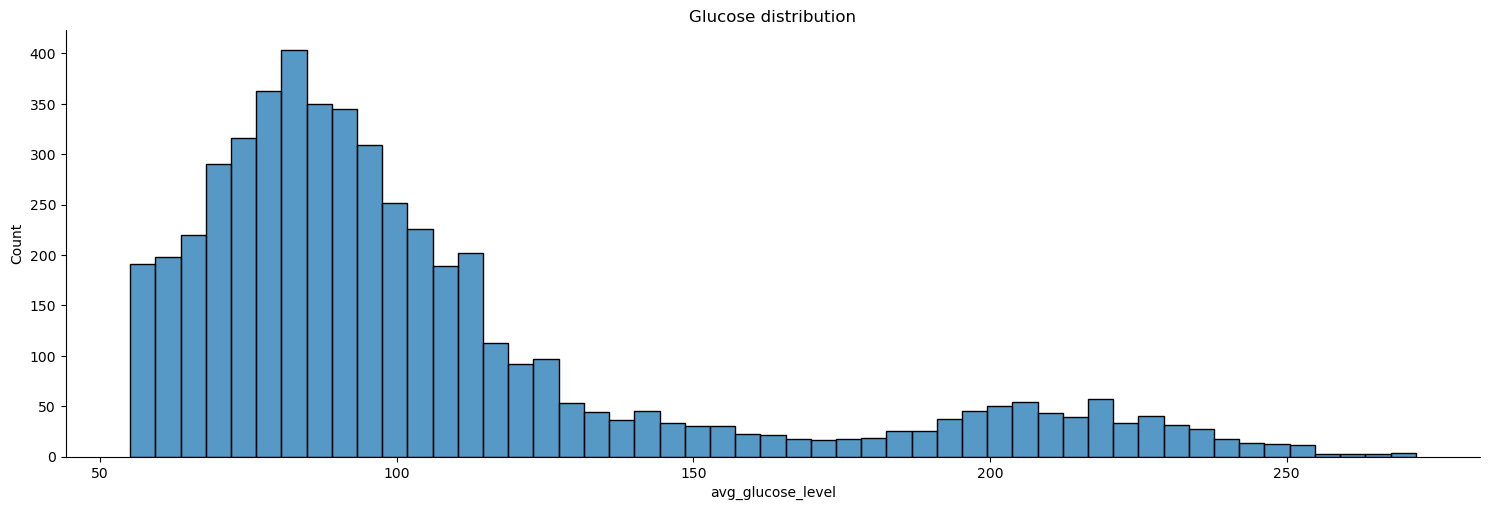

In [30]:
sns.displot(data=df, x="avg_glucose_level", height = 5, aspect = 15/5).set(title="Glucose distribution")

*Summary of findings:* Interestingly, there are 2 peaks in the distribution of avg_glucose_levels. The distribution is right-skewed.

In [31]:
fig = make_subplots(rows=2, cols=2, start_cell="bottom-left", subplot_titles=("Gender Gl", "Smoking Status Gl", "Ever married Gl", "Residence Type Gl"))

fig1 = px.box(data_frame=df,x="gender",y="avg_glucose_level",orientation="v", title="Gender", template = "seaborn" )
fig.add_trace(fig1.data[0], row=1, col=1)

fig2 = px.box(data_frame=df,x="smoking_status",y="avg_glucose_level",orientation="v", title="Smoking Status", template = "seaborn")
fig.add_trace(fig2.data[0], row=1, col=2)

fig3 = px.box(data_frame=df,x="ever_married",y="avg_glucose_level",orientation="v", title = "Ever Married",template = "seaborn")
fig.add_trace(fig3.data[0], row=2, col=1)

fig4 = px.box(data_frame=df,x="Residence_type",y="avg_glucose_level",orientation="v", title = "Residence Type", template = "seaborn")
fig.add_trace(fig4.data[0], row=2, col=2)


fig.update_layout(height=800, width=800)

In [32]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, start_cell="bottom-left", subplot_titles=("Gender BMI", "Smoking Status BMI", "Ever married BMI", "Residence Type BMI"))


fig5 = (px.box(data_frame=df,x="gender",y="bmi", orientation="v", title="Gender", template = "seaborn"))
fig.add_trace(fig5.data[0], row=1, col=1)

fig6 = px.box(data_frame=df,x="smoking_status",y="bmi", orientation="v", title ="Smoking Status",template = "seaborn")
fig.add_trace(fig6.data[0], row=1, col=2)

fig7 = px.box(data_frame=df,x="ever_married",y="bmi", orientation="v",title = "Ever Married", template = "seaborn")
fig.add_trace(fig7.data[0], row=2, col=1)

fig8 = px.box(data_frame=df,x="Residence_type",y="bmi", orientation="v", title = "Residence Type", template = "seaborn")
fig.add_trace(fig8.data[0], row=2, col=2)

fig.update_layout(height=800, width=800)


*Summary of findings:* 
From the box plots, we only see a few interesting learnings:
* The ever married seem to have a higher median bmi. This is also the case with glucose levels, but to lesser extent
* Smokers with status 'Unknown' have a little lower median BMI. 
* we see a potential for outliers with very high values for bmi and glucose levels, which also means that the mean values can be higher than the median values (we already saw this also based on the right-skewed distribution of the bmi)
* We will further look into a relationship between age, bmi/glucose level, stroke

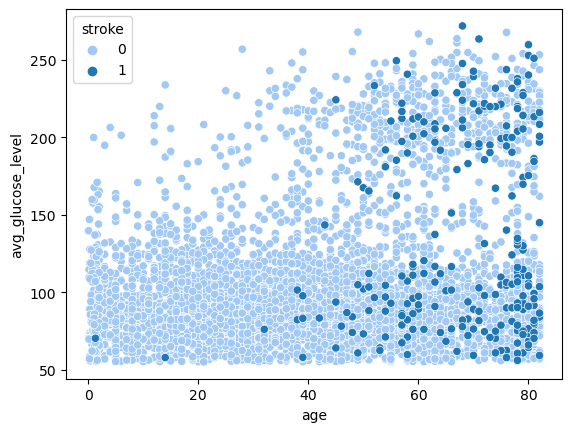

In [33]:
ax1 = sns.scatterplot(data=df[df.stroke == 0], x="age", y="avg_glucose_level", hue="stroke",palette ="pastel")
ax2 = sns.scatterplot(data=df[df.stroke == 1], x="age", y="avg_glucose_level", hue="stroke")

plt.show()

*Summary of findings:*
We can see that age is a huge factor in the probability of getting stroke. With growing age so do the observations with higher glucose levelss grow (>150) and there is a much higher concentration of people with stroke at these levels. It seems that glucose level will have an impact on the prediction of stroke.
What is also clear,what we already know from the correlations, is that age and glucose level are somewhat correlated.

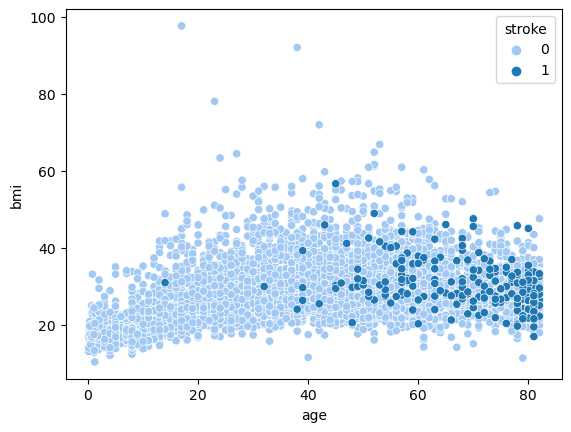

In [34]:
ax1 = sns.scatterplot(data=df[df.stroke == 0], x="age", y="bmi", hue="stroke",palette ="pastel")
ax2 = sns.scatterplot(data=df[df.stroke == 1], x="age", y="bmi", hue="stroke")

plt.show()

*Summary of findings:*
There  is no clear relationship between bmi and stroke, but we see the slight correlation between bmi and age as we know based on the correlation matrix and previous analysis. We could dive deeper into this variable, however, even based on this we can conclude that we will not remove the bmi variable.

# Basic feature engineering and selection

In this part we will perform the following:
* remove the column 'id', because this is not a feature that can help us in the prediction
* fill in the NaN values in the BMI column with a reasonable estimate
* turn the categorical variables into feature that the models can work with

I currently don't a reason to remove any of the additional features from the set:
* we don't have a huge set of features
* they all seem to be able to bring some value into the prediction. I will however experiment with feature selection libraries during the modelling part

We will remove only 1 column 'id', becase this is not a feature that can helps us in prediction. We will keep all the other provided columns.


In [35]:
df_features = df.copy()

In [36]:
df_features = df_features.drop(columns = "id")

We will remove the row with gender == 'Other'

In [37]:
df_features = df_features.drop(df[df.gender == 'Other'].index)

The only column with NA values is BMI. We are going to replace the BMI with a median. We will try to calcualte the median based on gender and then based on the variable ever_married as with the boxplot we saw that the median is different for Y/N.

In [38]:
df_features

gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0             Urban             228.69  36.6  formerly smoked       1  
1             Rural             202.21   NaN     never smoked       1  
2             Rural             105.92  32.5     never smoked       1  
3             Urban             171.23  34.4           smokes       1  
4             Rural             174.12  24.0     never smoked       1  
...             ...                ...   ...              ...     ...  
5105          Urban              83.75   NaN     never smoked       0  
5106          Urban             125.20  40.0     never smoked       0  
5107          Rural              82.99  30.6     never smoked       0  
5108          Rural             166.29  25.6  formerly smoked       0  
5109          Urban              85.28  26.2          Unknown       0  

[5109 rows x 11 columns]

In [39]:
median_bmi = df_features.groupby([df_features.ever_married,df.gender]).median().bmi.round(1).to_dict()
median_bmi[('Yes','Female')]

/var/folders/1_/qh2gt0m949d5_hzcd4src0vw0000gn/T/ipykernel_93228/2062196213.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



29.3

In [40]:
def bmi_guesser(married_gender):
    married_gender = tuple(married_gender)
    bmi = median_bmi[married_gender]
    return bmi

df_features.loc[df_features.bmi.isna(),"bmi"] = df_features.loc[df.bmi.isna(),["ever_married","gender"]].apply(bmi_guesser,axis=1)

In [41]:
df_features.loc[df_features.bmi.isna(),]

Empty DataFrame
Columns: [gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke]
Index: []

In [42]:
# we use this version of the datase to run further experiments with removing outliers, standardisation and normalisation
df_experiment = df_features.copy()

In [43]:
df_experiment


gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0             Urban             228.69  36.6  formerly smoked       1  
1             Rural             202.21  29.3     never smoked       1  
2             Rural             105.92  32.5     never smoked       1  
3             Urban             171.23  34.4           smokes       1  
4             Rural             174.12  24.0     never smoked       1  
...             ...                ...   ...              ...     ...  
5105          Urban              83.75  29.3     never smoked       0  
5106          Urban             125.20  40.0     never smoked       0  
5107          Rural              82.99  30.6     never smoked       0  
5108          Rural             166.29  25.6  formerly smoked       0  
5109          Urban              85.28  26.2          Unknown       0  

[5109 rows x 11 columns]

We will turn the categorical variables into features that our ML can work with.

## Dealing with categorical variables

In [44]:
# Converting numeric-binary value attributes to string
df_features[['hypertension', 'heart_disease', 'stroke']] = df_features[['hypertension', 'heart_disease', 'stroke']].astype(str)
# Generating dummy attributes with vectorisation one hot encoding
# dropping the first values for binary values
df_features_binary = pd.get_dummies(df_features[['hypertension', 'heart_disease','ever_married','gender','Residence_type','stroke']],drop_first = True)
# keeping the first values for non-binary values
df_features_non_binary = pd.get_dummies(df_features[['work_type','smoking_status']])
df_features_num = df_features[['bmi','avg_glucose_level','age']]
# concatenating together
df_features = pd.concat([df_features_num, df_features_non_binary, df_features_binary], axis=1)


In [45]:
df_features

bmi  avg_glucose_level   age  work_type_Govt_job  \
0     36.6             228.69  67.0                   0   
1     29.3             202.21  61.0                   0   
2     32.5             105.92  80.0                   0   
3     34.4             171.23  49.0                   0   
4     24.0             174.12  79.0                   0   
...    ...                ...   ...                 ...   
5105  29.3              83.75  80.0                   0   
5106  40.0             125.20  81.0                   0   
5107  30.6              82.99  35.0                   0   
5108  25.6             166.29  51.0                   0   
5109  26.2              85.28  44.0                   1   

      work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                          0                  1                        0   
1                          0                  0                        1   
2                          0                  1                        0   
3                          0                  1                        0   
4                          0                  0                        1   
...                      ...                ...                      ...   
5105                       0                  1                        0   
5106                       0                  0                        1   
5107                       0                  0                        1   
5108                       0                  1                        0   
5109                       0                  0                        0   

      work_type_children  smoking_status_Unknown  \
0                      0                       0   
1                      0                       0   
2                      0                       0   
3                      0                       0   
4                      0                       0   
...                  ...                     ...   
5105                   0                       0   
5106                   0                       0   
5107                   0                       0   
5108                   0                       0   
5109                   0                       1   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                                  1                            0   
1                                  0                            1   
2                                  0                            1   
3                                  0                            0   
4                                  0                            1   
...                              ...                          ...   
5105                               0                            1   
5106                               0                            1   
5107                               0                            1   
5108                               1                            0   
5109                               0                            0   

      smoking_status_smokes  hypertension_1  heart_disease_1  \
0                         0               0                1   
1                         0               0                0   
2                         0               0                1   
3                         1               0                0   
4                         0               1                0   
...                     ...             ...              ...   
5105                      0               1                0   
5106                      0               0                0   
5107                      0               0                0   
5108                      0               0                0   
5109                      0               0                0   

      ever_married_Yes  gender_Male  Residence_type_Urban  stroke_1  
0                    1            1                     1         1  
1                    1

In [46]:
# split into features and target
X = df_features.copy()
y = X.pop("stroke_1")

In [47]:
df_features.dtypes


bmi                               float64
avg_glucose_level                 float64
age                               float64
work_type_Govt_job                  uint8
work_type_Never_worked              uint8
work_type_Private                   uint8
work_type_Self-employed             uint8
work_type_children                  uint8
smoking_status_Unknown              uint8
smoking_status_formerly smoked      uint8
smoking_status_never smoked         uint8
smoking_status_smokes               uint8
hypertension_1                      uint8
heart_disease_1                     uint8
ever_married_Yes                    uint8
gender_Male                         uint8
Residence_type_Urban                uint8
stroke_1                            uint8
dtype: object

## Splitting into testing and training

In [48]:
from sklearn.model_selection import train_test_split

We will split the set in a standard way, 80% for training and 20% for testing.

In [49]:
df_processed = pd.concat([X,y],axis=1)
#significant_columns = scores[scores>0.1].index.tolist() +["SalePrice"]
df_processed

bmi  avg_glucose_level   age  work_type_Govt_job  \
0     36.6             228.69  67.0                   0   
1     29.3             202.21  61.0                   0   
2     32.5             105.92  80.0                   0   
3     34.4             171.23  49.0                   0   
4     24.0             174.12  79.0                   0   
...    ...                ...   ...                 ...   
5105  29.3              83.75  80.0                   0   
5106  40.0             125.20  81.0                   0   
5107  30.6              82.99  35.0                   0   
5108  25.6             166.29  51.0                   0   
5109  26.2              85.28  44.0                   1   

      work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                          0                  1                        0   
1                          0                  0                        1   
2                          0                  1                        0   
3                          0                  1                        0   
4                          0                  0                        1   
...                      ...                ...                      ...   
5105                       0                  1                        0   
5106                       0                  0                        1   
5107                       0                  0                        1   
5108                       0                  1                        0   
5109                       0                  0                        0   

      work_type_children  smoking_status_Unknown  \
0                      0                       0   
1                      0                       0   
2                      0                       0   
3                      0                       0   
4                      0                       0   
...                  ...                     ...   
5105                   0                       0   
5106                   0                       0   
5107                   0                       0   
5108                   0                       0   
5109                   0                       1   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                                  1                            0   
1                                  0                            1   
2                                  0                            1   
3                                  0                            0   
4                                  0                            1   
...                              ...                          ...   
5105                               0                            1   
5106                               0                            1   
5107                               0                            1   
5108                               1                            0   
5109                               0                            0   

      smoking_status_smokes  hypertension_1  heart_disease_1  \
0                         0               0                1   
1                         0               0                0   
2                         0               0                1   
3                         1               0                0   
4                         0               1                0   
...                     ...             ...              ...   
5105                      0               1                0   
5106                      0               0                0   
5107                      0               0                0   
5108                      0               0                0   
5109                      0               0                0   

      ever_married_Yes  gender_Male  Residence_type_Urban  stroke_1  
0                    1            1                     1         1  
1                    1

We will stratify the split to make sure that we have the same representation of stroke == 1 in both training and testing dataset

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y, random_state=0)

In [51]:
len(y_train[y_train == 1])/len(y_train)


0.04869097137264497

In [52]:
len(y_test[y_test == 1])/len(y_test)

0.04892367906066536

# Model training and evaluation

## Modelling without sample balancing

In [53]:
# import all libraries that we will need for running and evaluating the models
# models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# pipeline
from imblearn.pipeline import Pipeline



We will first try very quickly the most famous classifier models that we know. We will approach it in a following way:
1. use stratified kfold crossvalidation on the balanced training set
2. fit the model, make predictions for the testing set
    * create classification report
    * confusion matrix on the testing set
3. analyze the results
    * decide on the best one from this set of models
    * decide on what could be the next steps towards a better performing model

In [54]:
models_def = [("logReg", (LogisticRegression(max_iter=1000, random_state=0))),
          ("MLP", (MLPClassifier(hidden_layer_sizes=(20,10),max_iter=2000, random_state=0))),
          ("decTree",(DecisionTreeClassifier(random_state=0))),
          ("randForest",(RandomForestClassifier(random_state=0))),
          ("KNN",KNeighborsClassifier()),
          ("SVC", SVC(random_state=0)),
          ("GaussNB", GaussianNB()),
          ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=0)),
          ("GradBoost", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
          ("XGBoost",  XGBClassifier(random_state=0))]



In [55]:
def model_evaluate(model,X_train,y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    msg = "%s: %f (%f)" % (model_name, mean(scores), scores.std())
    results.append(scores)
    print(msg)
    return model

In [56]:
def visualise_models_performance(results,models):
    fig, ax = plt.subplots()
    ax.boxplot(results)
    ax.set_xticklabels(models)
    plt.xticks(rotation=45)
    ax.set_xlabel("Model")
    ax.set_ylabel("ROC AUC score")
    plt.show()

In [57]:
def model_fit_pred(model,X_train, y_train):
    model = model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    return y_test_pred

In [58]:
def class_report(y_test_pred,y_test):
    report = classification_report(y_true=y_test, y_pred=y_test_pred)
    print(report)

In [59]:
def conf_matrix(y_test_pred,y_test):
    cf = pd.DataFrame(
        columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"])
    cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_pred)
    display(cf)

In [60]:
models = []
results = []
for name, model in models_def:
    model_name = name
    models.append(model_name)
    y_test_pred = model_fit_pred(model,X_train, y_train)
    model_evaluate(model,X_train, y_train)
    class_report(y_test_pred,y_test)
    conf_matrix(y_test_pred,y_test)
    

logReg: 0.846718 (0.040915)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022



y_test_0 y_test_1
y_pred_0      972        0
y_pred_1       49        1

MLP: 0.811254 (0.048509)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



y_test_0 y_test_1
y_pred_0      972        0
y_pred_1       50        0

decTree: 0.566540 (0.045883)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.15      0.18      0.16        50

    accuracy                           0.91      1022
   macro avg       0.55      0.56      0.56      1022
weighted avg       0.92      0.91      0.91      1022



y_test_0 y_test_1
y_pred_0      920       52
y_pred_1       41        9

randForest: 0.804861 (0.057972)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



y_test_0 y_test_1
y_pred_0      971        1
y_pred_1       50        0

KNN: 0.658819 (0.056939)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.92      1022



y_test_0 y_test_1
y_pred_0      967        5
y_pred_1       50        0

SVC: 0.668264 (0.103829)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



y_test_0 y_test_1
y_pred_0      972        0
y_pred_1       50        0

GaussNB: 0.812170 (0.046938)
              precision    recall  f1-score   support

           0       0.99      0.53      0.69       972
           1       0.09      0.90      0.16        50

    accuracy                           0.55      1022
   macro avg       0.54      0.71      0.42      1022
weighted avg       0.95      0.55      0.66      1022



y_test_0 y_test_1
y_pred_0      512      460
y_pred_1        5       45

AdaBoost: 0.826974 (0.050286)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.20      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.58      0.51      0.50      1022
weighted avg       0.92      0.95      0.93      1022



y_test_0 y_test_1
y_pred_0      968        4
y_pred_1       49        1

GradBoost: 0.839157 (0.036936)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



y_test_0 y_test_1
y_pred_0      968        4
y_pred_1       50        0

XGBoost: 0.806379 (0.041661)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.94      1022
   macro avg       0.48      0.49      0.48      1022
weighted avg       0.90      0.94      0.92      1022



y_test_0 y_test_1
y_pred_0      959       13
y_pred_1       50        0

In [61]:
mean_results = [mean(result) for result in results]
for model, result in zip(models, mean_results):
    print(model, result)
    visualise_models_performance

logReg 0.8467176644205059
MLP 0.8112538735928949
decTree 0.5665404357765854
randForest 0.8048606462605911
KNN 0.658818981337477
SVC 0.6682641218469011
GaussNB 0.812169871665223
AdaBoost 0.8269738332842814
GradBoost 0.8391574011370754
XGBoost 0.806378829364775


**All these models are performing weakly** and are not usable in real life.  While on stroke == 0 they perform well, they are not able or are very weak in predicting stroke == 1. From all the models I tried, only a few were ale to do at least some prediction for stroke ==1 (f1 !=0 ) and only the Gaussian Naive Bayes was able to predict stroke, with and F1 score of 0.16 (recall of 0.9) for stroke == 1.


In this case I believe that **recall for stroke == 1 is the more important aspect of the f1 score**, because I consider the **consequences of missing a stroke (false negatives) more severe and harmful than making a prediction that a patient will have stroke when they won't have it** (which would be **false positives** in this situation). Of course there needs to be a balance, but in general I will be looking into making the prediction in general, and recall for stroke == 1 in particular, better.

## Modelling with sample balancing and pipeline

We will use SMOTE oversampling and undersampling to achieve a better balanced set in terms of stroke == 1.
We will also use pipeline which improves the performance and results of using balancing techniques with a model.

The way we will apply this, similarly to the modelling without sample balancing:
1. create pipeline
   * the under/oversampling will happen on the training set
2. fit the model and use stratified kfold crossvalidation on the balanced training set
3. make predictions for the testing set and
   * create classification report
   * confusion matrix on the testing set

In [62]:
# balancing libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# other
from numpy import where

We will select the sampling strategy in SMOTE to 0.1 and oversamling to 0.5. Based on the the recommendation from the data science community, combining undersampling with oversampling in this proportion is a good starting point and is mostly optimal in terms of results.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y, random_state=0)

In [64]:
def pipeline_define(model):
    over = SMOTE(sampling_strategy=0.1) # sampling strategy sets the ratio of the minority / majority class
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    return pipeline

In [65]:
models = []
results = []
for name, model in models_def:
    model_name = name
    models.append(model_name)
    pipeline = pipeline_define(model)
    model_evaluate(pipeline,X_train, y_train)
    y_test_pred = model_fit_pred(pipeline, X_train, y_train)
    class_report(y_test_pred, y_test)
    cf = conf_matrix(y_test_pred, y_test)

logReg: 0.841895 (0.041272)
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       972
           1       0.17      0.44      0.25        50

    accuracy                           0.87      1022
   macro avg       0.57      0.66      0.59      1022
weighted avg       0.93      0.87      0.89      1022



y_test_0 y_test_1
y_pred_0      865      107
y_pred_1       28       22

MLP: 0.824980 (0.039733)
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       972
           1       0.15      0.34      0.21        50

    accuracy                           0.88      1022
   macro avg       0.56      0.62      0.57      1022
weighted avg       0.92      0.88      0.90      1022



y_test_0 y_test_1
y_pred_0      879       93
y_pred_1       33       17

decTree: 0.621243 (0.058824)
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       972
           1       0.14      0.54      0.22        50

    accuracy                           0.82      1022
   macro avg       0.56      0.69      0.56      1022
weighted avg       0.93      0.82      0.86      1022



y_test_0 y_test_1
y_pred_0      807      165
y_pred_1       23       27

randForest: 0.825322 (0.039685)
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.12      0.32      0.18        50

    accuracy                           0.86      1022
   macro avg       0.54      0.60      0.55      1022
weighted avg       0.92      0.86      0.88      1022



y_test_0 y_test_1
y_pred_0      858      114
y_pred_1       34       16

KNN: 0.773627 (0.058197)
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       972
           1       0.13      0.54      0.21        50

    accuracy                           0.80      1022
   macro avg       0.55      0.68      0.55      1022
weighted avg       0.93      0.80      0.86      1022



y_test_0 y_test_1
y_pred_0      795      177
y_pred_1       23       27

SVC: 0.847813 (0.038561)
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.13      0.60      0.22        50

    accuracy                           0.79      1022
   macro avg       0.55      0.70      0.55      1022
weighted avg       0.93      0.79      0.84      1022



y_test_0 y_test_1
y_pred_0      774      198
y_pred_1       20       30

GaussNB: 0.807458 (0.050848)
              precision    recall  f1-score   support

           0       0.99      0.41      0.58       972
           1       0.08      0.96      0.14        50

    accuracy                           0.43      1022
   macro avg       0.54      0.68      0.36      1022
weighted avg       0.95      0.43      0.56      1022



y_test_0 y_test_1
y_pred_0      395      577
y_pred_1        2       48

AdaBoost: 0.812149 (0.043639)
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       972
           1       0.13      0.38      0.20        50

    accuracy                           0.85      1022
   macro avg       0.55      0.63      0.56      1022
weighted avg       0.92      0.85      0.88      1022



y_test_0 y_test_1
y_pred_0      850      122
y_pred_1       31       19

GradBoost: 0.825546 (0.035074)
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.12      0.32      0.18        50

    accuracy                           0.86      1022
   macro avg       0.54      0.60      0.55      1022
weighted avg       0.92      0.86      0.88      1022



y_test_0 y_test_1
y_pred_0      859      113
y_pred_1       34       16

XGBoost: 0.810420 (0.040398)
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       972
           1       0.12      0.30      0.17        50

    accuracy                           0.86      1022
   macro avg       0.54      0.59      0.55      1022
weighted avg       0.92      0.86      0.89      1022



y_test_0 y_test_1
y_pred_0      865      107
y_pred_1       35       15

In [66]:
mean_results = [mean(result) for result in results]
for model, result in zip(models, mean_results):
    print(model, result)

logReg 0.8418952609540441
MLP 0.824980150814983
decTree 0.6212433390475366
randForest 0.8253216415920542
KNN 0.7736265044534985
SVC 0.8478128671631374
GaussNB 0.8074584087129282
AdaBoost 0.812148876094312
GradBoost 0.8255460920358699
XGBoost 0.8104201223881


Using balancing has significantly improved the performance of certain models, where previously most models were not able do a prediction for stroke == 1 in general, and recall for stroke == 1 in particular. 
We can conclude that including balancing has made a huge difference and we will keep balancing in the further experiments we will try.

Note: I have also tried with different balancing sampling strategies, but this seems to work best.

It is difficult to select a best performing model, as all of them are still weak in terms of performance. 

From all these models, I would select the SVC or KNN as the best performing models, because of the relatively high recall for stroke == 1 (compared to other models) (0.6), while keeping a decent performance for stroke == 0.

While the Gaussian NB still has a very high recall for stroke == 1, it performs poorly in the other metrics (e.g recall for 0 = 0.38) and also has a very low precision for stroke == 1. Even though there are some models that are performing better in the other metrics, but becuase of the recall for stroke == 1, this is what I would select.


## Adding more advance feature engineering and selection

Compared to the previous version of the models, we will play around with column transformation in a bit more advanced way.
We will keep the following:
* preprocessing: removing id, removing row with 'Other' as gender, replacing NaN in BMI with values from our BMI_guesser function
* SMOTE overbalancing, underbalancing with the same parameters as before (this seems to work best for our set)
* working with pipeline
* cross-validation on the training set

We will add:
* creating  ColumnTransformer  and adding it to the pipeline 
    * scaler on numerical values  (StandardScaler)
        * Note: I also tried with StandardScaler but the results were slightly worse
    * one hot encoding on categorical values
    * feature selection with SelectPercentile(chi2, percentile=50)

Note: for the changes I followed parts of this tutorial on skicit learn https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2



In [98]:
numeric_features = ['bmi','avg_glucose_level','age']
categorical_features = ['hypertension', 'heart_disease','ever_married','gender','Residence_type', 'work_type','smoking_status']

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)    
    ]
)

In [99]:
# for ColumnTransformer we need to import the pipeline from imblearn
from imblearn.pipeline import Pipeline

In [100]:
def pipeline_preprocessor_define(model):  
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('preprocess', preprocessor), ('o', over), ('u', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    return pipeline


In [101]:
# split into features and target
X = df_experiment.copy()
y = X.pop("stroke")

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [103]:
models = []
results = []
for name, model in models_def:
    model_name = name
    models.append(model_name)
    pipeline = pipeline_preprocessor_define(model)
    model_evaluate(pipeline, X_train, y_train)
    y_test_pred = model_fit_pred(pipeline, X_train, y_train)
    class_report(y_test_pred, y_test)
    cf = conf_matrix(y_test_pred, y_test)
    
    

logReg: 0.839433 (0.026195)
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.18      0.74      0.29        50

    accuracy                           0.83      1022
   macro avg       0.58      0.79      0.60      1022
weighted avg       0.94      0.83      0.87      1022



y_test_0 y_test_1
y_pred_0      807      165
y_pred_1       13       37

MLP: 0.784384 (0.043105)
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       972
           1       0.15      0.54      0.24        50

    accuracy                           0.83      1022
   macro avg       0.56      0.69      0.57      1022
weighted avg       0.93      0.83      0.87      1022



y_test_0 y_test_1
y_pred_0      820      152
y_pred_1       23       27

decTree: 0.627203 (0.048766)
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       972
           1       0.14      0.58      0.23        50

    accuracy                           0.81      1022
   macro avg       0.56      0.70      0.56      1022
weighted avg       0.93      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      796      176
y_pred_1       21       29

randForest: 0.808816 (0.028146)
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.17      0.52      0.26        50

    accuracy                           0.86      1022
   macro avg       0.57      0.70      0.59      1022
weighted avg       0.93      0.86      0.89      1022



y_test_0 y_test_1
y_pred_0      848      124
y_pred_1       24       26

KNN: 0.748045 (0.057175)
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       972
           1       0.15      0.66      0.24        50

    accuracy                           0.80      1022
   macro avg       0.56      0.73      0.56      1022
weighted avg       0.94      0.80      0.85      1022



y_test_0 y_test_1
y_pred_0      780      192
y_pred_1       17       33

SVC: 0.812768 (0.044951)
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.17      0.74      0.28        50

    accuracy                           0.81      1022
   macro avg       0.58      0.78      0.58      1022
weighted avg       0.94      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      791      181
y_pred_1       13       37

GaussNB: 0.798438 (0.037637)
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       972
           1       0.09      0.78      0.17        50

    accuracy                           0.62      1022
   macro avg       0.54      0.70      0.46      1022
weighted avg       0.94      0.62      0.73      1022



y_test_0 y_test_1
y_pred_0      598      374
y_pred_1       11       39

AdaBoost: 0.804320 (0.048571)
              precision    recall  f1-score   support

           0       0.98      0.83      0.89       972
           1       0.15      0.60      0.24        50

    accuracy                           0.81      1022
   macro avg       0.56      0.71      0.57      1022
weighted avg       0.94      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      802      170
y_pred_1       20       30

GradBoost: 0.822249 (0.039066)
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       972
           1       0.15      0.60      0.24        50

    accuracy                           0.81      1022
   macro avg       0.56      0.71      0.56      1022
weighted avg       0.94      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      799      173
y_pred_1       20       30

XGBoost: 0.798162 (0.034438)
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       972
           1       0.14      0.46      0.22        50

    accuracy                           0.84      1022
   macro avg       0.56      0.66      0.56      1022
weighted avg       0.93      0.84      0.88      1022



y_test_0 y_test_1
y_pred_0      834      138
y_pred_1       27       23

In [104]:
mean_results = [mean(result) for result in results]
for model, result in zip(models, mean_results):
    print(model, result)

logReg 0.8394333575803395
MLP 0.78438365121786
decTree 0.6272031055230636
randForest 0.8088159263425703
KNN 0.7480451095439284
SVC 0.8127678294535797
GaussNB 0.7984376832183285
AdaBoost 0.8043204230230785
GradBoost 0.8222487023318507
XGBoost 0.7981615823507834


Using standard scaler with oversampling and undersampline helped significantly in certain models in terms of recall for stroke == 1. This is good news. From these models, I would select Logistic Regression and SVC as the best performing. The are both performing much better in terms of recall for stroke == 1 (0.74 for both on my run) which is a huge improvement compared to the previous results. At the same time, they also perform much better in terms of recall for stroke == 1 (0.18 for logreg, 0.17 for svc on my run - still weak though) and keep a decent performance in terms of prediction for stroke == 1.


We will continue with this setting and try to focus on removing the outliers in the numeric features and I will also try to apply PCA.

Note: I have also tried with StandardScaler, but the MinMaxScaler produced slightly better results.

## Removing outliers

### First experiment with RobustScaler

We have seen some outliers in the BMI and avg_glucose_levels and we will try with the RobustScaler, which normally handles outliers better.

In [75]:
from sklearn.preprocessing import RobustScaler

In [76]:
numeric_transformer = Pipeline(
    steps=[("scaler", RobustScaler())]
)


In [77]:
models = []
results = []
for name, model in models_def:
    model_name = name
    models.append(model_name)
    pipeline = pipeline_preprocessor_define(model)
    model_evaluate(pipeline, X_train, y_train)
    y_test_pred = model_fit_pred(pipeline, X_train, y_train)
    class_report(y_test_pred, y_test)
    cf = conf_matrix(y_test_pred, y_test)

logReg: 0.840203 (0.026781)
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       972
           1       0.19      0.74      0.31        50

    accuracy                           0.84      1022
   macro avg       0.59      0.79      0.61      1022
weighted avg       0.95      0.84      0.88      1022



y_test_0 y_test_1
y_pred_0      819      153
y_pred_1       13       37

MLP: 0.770277 (0.042915)
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.16      0.60      0.25        50

    accuracy                           0.82      1022
   macro avg       0.57      0.72      0.57      1022
weighted avg       0.94      0.82      0.87      1022



y_test_0 y_test_1
y_pred_0      811      161
y_pred_1       20       30

decTree: 0.649419 (0.030718)
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       972
           1       0.13      0.48      0.21        50

    accuracy                           0.82      1022
   macro avg       0.55      0.66      0.55      1022
weighted avg       0.93      0.82      0.86      1022



y_test_0 y_test_1
y_pred_0      814      158
y_pred_1       26       24

randForest: 0.804300 (0.028460)
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       972
           1       0.20      0.60      0.30        50

    accuracy                           0.87      1022
   macro avg       0.59      0.74      0.62      1022
weighted avg       0.94      0.87      0.90      1022



y_test_0 y_test_1
y_pred_0      855      117
y_pred_1       20       30

KNN: 0.746766 (0.056667)
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.12      0.56      0.20        50

    accuracy                           0.78      1022
   macro avg       0.55      0.68      0.54      1022
weighted avg       0.93      0.78      0.84      1022



y_test_0 y_test_1
y_pred_0      769      203
y_pred_1       22       28

SVC: 0.815191 (0.041495)
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.17      0.72      0.27        50

    accuracy                           0.81      1022
   macro avg       0.57      0.77      0.58      1022
weighted avg       0.94      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      792      180
y_pred_1       14       36

GaussNB: 0.802325 (0.037020)
              precision    recall  f1-score   support

           0       0.98      0.63      0.77       972
           1       0.10      0.76      0.17        50

    accuracy                           0.64      1022
   macro avg       0.54      0.70      0.47      1022
weighted avg       0.94      0.64      0.74      1022



y_test_0 y_test_1
y_pred_0      613      359
y_pred_1       12       38

AdaBoost: 0.803194 (0.041514)
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       972
           1       0.14      0.56      0.22        50

    accuracy                           0.81      1022
   macro avg       0.56      0.69      0.56      1022
weighted avg       0.93      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      801      171
y_pred_1       22       28

GradBoost: 0.817970 (0.029434)
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.14      0.60      0.23        50

    accuracy                           0.80      1022
   macro avg       0.56      0.71      0.56      1022
weighted avg       0.93      0.80      0.85      1022



y_test_0 y_test_1
y_pred_0      788      184
y_pred_1       20       30

XGBoost: 0.794625 (0.034388)
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.17      0.52      0.25        50

    accuracy                           0.85      1022
   macro avg       0.57      0.69      0.58      1022
weighted avg       0.93      0.85      0.88      1022



y_test_0 y_test_1
y_pred_0      841      131
y_pred_1       24       26

The RobustScaler doesn't seem to produce better results, and even makes them slightly worse than before. 

### Manual removal of outliers

In [78]:
X_train_no_out = X_train.copy()

In [79]:
def remove_outliers(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.2) # a little bit higher than the normal quantiles, to focus on real outliers
        Q3 = df[col].quantile(0.8)
        IQR = Q3 - Q1

        low = (Q1 - 1.5 * IQR).round(1)
        high = (Q3 + 1.5 * IQR).round(1)

        df[col] = np.where(df[col] < low, low, df[col])
        df[col] = np.where(df[col] > high, high, df[col])

    return df

In [80]:
X_train_no_out[['bmi', 'avg_glucose_level']] = remove_outliers(X_train_no_out[['bmi', 'avg_glucose_level']])

/var/folders/1_/qh2gt0m949d5_hzcd4src0vw0000gn/T/ipykernel_93228/2019072898.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1_/qh2gt0m949d5_hzcd4src0vw0000gn/T/ipykernel_93228/2019072898.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1_/qh2gt0m949d5_hzcd4src0vw0000gn/T/ipykernel_93228/2019072898.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [81]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)    
    ]
)

In [82]:
models = []
results = []
for name, model in models_def:
    model_name = name
    models.append(model_name)
    pipeline = pipeline_preprocessor_define(model)
    model_evaluate(pipeline, X_train_no_out, y_train)
    y_test_pred = model_fit_pred(pipeline, X_train_no_out, y_train)
    class_report(y_test_pred, y_test)
    cf = conf_matrix(y_test_pred, y_test)

logReg: 0.839078 (0.026495)
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.20      0.72      0.31        50

    accuracy                           0.85      1022
   macro avg       0.59      0.79      0.61      1022
weighted avg       0.95      0.85      0.88      1022



y_test_0 y_test_1
y_pred_0      828      144
y_pred_1       14       36

MLP: 0.775530 (0.035608)
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.13      0.60      0.22        50

    accuracy                           0.79      1022
   macro avg       0.55      0.70      0.55      1022
weighted avg       0.93      0.79      0.84      1022



y_test_0 y_test_1
y_pred_0      774      198
y_pred_1       20       30

decTree: 0.624443 (0.044760)
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.12      0.54      0.20        50

    accuracy                           0.79      1022
   macro avg       0.55      0.67      0.54      1022
weighted avg       0.93      0.79      0.85      1022



y_test_0 y_test_1
y_pred_0      779      193
y_pred_1       23       27

randForest: 0.813463 (0.033797)
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.17      0.50      0.25        50

    accuracy                           0.86      1022
   macro avg       0.57      0.69      0.59      1022
weighted avg       0.93      0.86      0.89      1022



y_test_0 y_test_1
y_pred_0      850      122
y_pred_1       25       25

KNN: 0.757740 (0.053728)
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       972
           1       0.12      0.50      0.19        50

    accuracy                           0.79      1022
   macro avg       0.54      0.65      0.54      1022
weighted avg       0.93      0.79      0.85      1022



y_test_0 y_test_1
y_pred_0      787      185
y_pred_1       25       25

SVC: 0.815258 (0.038623)
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.18      0.72      0.28        50

    accuracy                           0.82      1022
   macro avg       0.58      0.77      0.59      1022
weighted avg       0.94      0.82      0.87      1022



y_test_0 y_test_1
y_pred_0      805      167
y_pred_1       14       36

GaussNB: 0.802827 (0.036435)
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       972
           1       0.09      0.78      0.17        50

    accuracy                           0.62      1022
   macro avg       0.54      0.70      0.46      1022
weighted avg       0.94      0.62      0.73      1022



y_test_0 y_test_1
y_pred_0      599      373
y_pred_1       11       39

AdaBoost: 0.815767 (0.036243)
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       972
           1       0.16      0.60      0.25        50

    accuracy                           0.82      1022
   macro avg       0.57      0.72      0.58      1022
weighted avg       0.94      0.82      0.87      1022



y_test_0 y_test_1
y_pred_0      813      159
y_pred_1       20       30

GradBoost: 0.825073 (0.030881)
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       972
           1       0.12      0.46      0.20        50

    accuracy                           0.82      1022
   macro avg       0.55      0.65      0.55      1022
weighted avg       0.93      0.82      0.86      1022



y_test_0 y_test_1
y_pred_0      811      161
y_pred_1       27       23

XGBoost: 0.798461 (0.030574)
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       972
           1       0.18      0.60      0.27        50

    accuracy                           0.84      1022
   macro avg       0.58      0.73      0.59      1022
weighted avg       0.94      0.84      0.88      1022



y_test_0 y_test_1
y_pred_0      832      140
y_pred_1       20       30

There are no improvements from manual outlier handling.

## Experiment with PCA

We will try PCA to reduce the dimensionality of the data.

In [83]:
from sklearn.decomposition import PCA

In [84]:
X_train

gender   age  hypertension  heart_disease ever_married work_type  \
845   Female  48.0             0              0          Yes   Private   
3745  Female  29.0             0              0           No   Private   
4184  Female  35.0             0              0          Yes   Private   
3410    Male  38.0             0              0          Yes   Private   
284     Male  14.0             0              0           No  Govt_job   
...      ...   ...           ...            ...          ...       ...   
1434  Female  45.0             0              0          Yes   Private   
461   Female  16.0             0              0           No  children   
1052  Female  61.0             0              0          Yes   Private   
1757    Male  31.0             0              0          Yes   Private   
5053  Female  46.0             0              0          Yes  Govt_job   

     Residence_type  avg_glucose_level   bmi   smoking_status  
845           Urban              69.21  33.1     never smoked  
3745          Urban              84.19  21.2     never smoked  
4184          Rural             119.40  22.9     never smoked  
3410          Rural             108.68  32.7     never smoked  
284           Urban              82.34  31.6          Unknown  
...             ...                ...   ...              ...  
1434          Urban              92.86  35.1  formerly smoked  
461           Rural             113.47  19.5          Unknown  
1052          Rural              78.65  36.2  formerly smoked  
1757          Urban              74.05  26.0          Unknown  
5053          Urban              55.84  27.8     never smoked  

[4087 rows x 10 columns]

In [85]:
df_experiment[categorical_features]

hypertension  heart_disease ever_married  gender Residence_type  \
0                0              1          Yes    Male          Urban   
1                0              0          Yes  Female          Rural   
2                0              1          Yes    Male          Rural   
3                0              0          Yes  Female          Urban   
4                1              0          Yes  Female          Rural   
...            ...            ...          ...     ...            ...   
5105             1              0          Yes  Female          Urban   
5106             0              0          Yes  Female          Urban   
5107             0              0          Yes  Female          Rural   
5108             0              0          Yes    Male          Rural   
5109             0              0          Yes  Female          Urban   

          work_type   smoking_status  
0           Private  formerly smoked  
1     Self-employed     never smoked  
2           Private     never smoked  
3           Private           smokes  
4     Self-employed     never smoked  
...             ...              ...  
5105        Private     never smoked  
5106  Self-employed     never smoked  
5107  Self-employed     never smoked  
5108        Private  formerly smoked  
5109       Govt_job          Unknown  

[5109 rows x 7 columns]

In [86]:
# It doesn't seem reasonable to use both SelectPerentile and PCA, because our data is not that high-dimensional
# and I also tried running a pipeline without SelectPercentile previously and it did not render sognificantly different results

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
        #("selector", SelectPercentile(chi2, percentile=50)),
    ])   
      
def pipeline_preprocessor_define(model):  
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    pca = PCA()
    steps = [('preprocess', preprocessor), ('o', over), ('u', under), ('PCA', pca), ('model', model)]
    pipeline = Pipeline(steps=steps)
    return pipeline


In [87]:
models = []
results = []
for name, model in models_def:
    model_name = name
    models.append(model_name)
    pipeline = pipeline_preprocessor_define(model)
    model_evaluate(pipeline, X_train_no_out, y_train)
    y_test_pred = model_fit_pred(pipeline, X_train_no_out, y_train)
    class_report(y_test_pred, y_test)
    cf = conf_matrix(y_test_pred, y_test)

logReg: 0.840410 (0.025373)
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       972
           1       0.19      0.74      0.30        50

    accuracy                           0.83      1022
   macro avg       0.59      0.79      0.60      1022
weighted avg       0.95      0.83      0.87      1022



y_test_0 y_test_1
y_pred_0      813      159
y_pred_1       13       37

MLP: 0.768183 (0.041102)
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       972
           1       0.16      0.52      0.24        50

    accuracy                           0.84      1022
   macro avg       0.57      0.69      0.58      1022
weighted avg       0.93      0.84      0.88      1022



y_test_0 y_test_1
y_pred_0      834      138
y_pred_1       24       26

decTree: 0.640626 (0.056595)
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       972
           1       0.11      0.42      0.18        50

    accuracy                           0.81      1022
   macro avg       0.54      0.62      0.53      1022
weighted avg       0.92      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      804      168
y_pred_1       29       21

randForest: 0.798503 (0.036547)
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.18      0.56      0.27        50

    accuracy                           0.85      1022
   macro avg       0.58      0.71      0.60      1022
weighted avg       0.94      0.85      0.89      1022



y_test_0 y_test_1
y_pred_0      844      128
y_pred_1       22       28

KNN: 0.757586 (0.053754)
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       972
           1       0.12      0.50      0.20        50

    accuracy                           0.80      1022
   macro avg       0.55      0.66      0.54      1022
weighted avg       0.93      0.80      0.85      1022



y_test_0 y_test_1
y_pred_0      793      179
y_pred_1       25       25

SVC: 0.805667 (0.044555)
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       972
           1       0.17      0.70      0.27        50

    accuracy                           0.81      1022
   macro avg       0.57      0.76      0.58      1022
weighted avg       0.94      0.81      0.86      1022



y_test_0 y_test_1
y_pred_0      797      175
y_pred_1       15       35

GaussNB: 0.822327 (0.032917)
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.15      0.66      0.25        50

    accuracy                           0.80      1022
   macro avg       0.57      0.74      0.57      1022
weighted avg       0.94      0.80      0.86      1022



y_test_0 y_test_1
y_pred_0      788      184
y_pred_1       17       33

AdaBoost: 0.776639 (0.041564)
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       972
           1       0.13      0.48      0.20        50

    accuracy                           0.82      1022
   macro avg       0.55      0.66      0.55      1022
weighted avg       0.93      0.82      0.86      1022



y_test_0 y_test_1
y_pred_0      809      163
y_pred_1       26       24

GradBoost: 0.802501 (0.035826)
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       972
           1       0.14      0.50      0.22        50

    accuracy                           0.83      1022
   macro avg       0.56      0.67      0.56      1022
weighted avg       0.93      0.83      0.87      1022



y_test_0 y_test_1
y_pred_0      823      149
y_pred_1       25       25

XGBoost: 0.783118 (0.035273)
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       972
           1       0.16      0.56      0.25        50

    accuracy                           0.84      1022
   macro avg       0.57      0.71      0.58      1022
weighted avg       0.93      0.84      0.88      1022



y_test_0 y_test_1
y_pred_0      828      144
y_pred_1       22       28

PCA hasn't improved the results in our best performing models. I tried with both version, with and without outlier handling and the outlier handling seems to contribute to better results when in combination with PCA.

## Hyperparameter finetuning on our best performant models

In this part I will try to finetune the hyperparameters with the use of GridSearchCV of the 2 best performing models: logistic regression and SVC, which produced the best results so far.

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)


In [90]:
def pipeline_preprocess_define(model):  
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('preprocess', preprocessor), ('o', over), ('u', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    return pipeline


In [91]:
# define models and parameters that I want to try
model = LogisticRegression(max_iter = 3000)
pipeline = pipeline_preprocess_define(model)

C = [0.5,1,1.5,2,2.5]
max_iter = [1000, 2000, 3000]
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
penalty = ['l2','l1']
parameters = dict(model__C=C, model__penalty=penalty, model__solver=solver, model__max_iter = max_iter)
# define grid search
clf = GridSearchCV(pipeline, parameters)
clf.fit(X_train, y_train)
print('Best penalty:', clf.best_estimator_.get_params()['model__penalty'])
print('Best C:', clf.best_estimator_.get_params()['model__C'])
print('Best solver:', clf.best_estimator_.get_params()['model__solver'])
print('Best max iter:', clf.best_estimator_.get_params()['model__max_iter'])


Best penalty: l2
Best C: 1
Best solver: newton-cg
Best max iter: 3000


/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


225 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/katarinalechner/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logis

In [92]:
model_def = ('logReg', LogisticRegression(C=clf.best_estimator_.get_params()['model__C'], 
                                          penalty=clf.best_estimator_.get_params()['model__penalty'],
                                          random_state=0,
                                          max_iter=clf.best_estimator_.get_params()['model__max_iter'],
                                          solver=clf.best_estimator_.get_params()['model__solver']))
model_name = model_def[0]
model = model_def[1]
pipeline = pipeline_preprocess_define(model)
model_evaluate(pipeline, X_train, y_train)
y_test_pred = model_fit_pred(pipeline, X_train, y_train)
class_report(y_test_pred, y_test)
cf = conf_matrix(y_test_pred, y_test)

logReg: 0.839392 (0.025509)
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.19      0.72      0.31        50

    accuracy                           0.84      1022
   macro avg       0.59      0.78      0.61      1022
weighted avg       0.94      0.84      0.88      1022



y_test_0 y_test_1
y_pred_0      822      150
y_pred_1       14       36

I am not able to achieve a better result with hyperparameter tuning on logistic regression.

In [94]:
model = SVC(random_state=0)
pipeline = pipeline_preprocess_define(model)

C = [0.1,1, 10, 100]
gamma = [1,0.1,0.01,0.001]
kernel = ['rbf', 'poly', 'sigmoid']
parameters = dict(model__C=C, model__kernel=kernel, model__gamma=gamma)
# define grid search
clf = GridSearchCV(pipeline, parameters)
clf.fit(X_train, y_train)
print('Best C:', clf.best_estimator_.get_params()['model__C'])
print('Best kernel:', clf.best_estimator_.get_params()['model__kernel'])
print('Best gamma:', clf.best_estimator_.get_params()['model__gamma'])
#sorted(clf.cv_results_.keys())

Best C: 10
Best kernel: poly
Best gamma: 0.01


In [105]:
# define models and parameters that I want to try
model_def = ('SVC' ,SVC(C=clf.best_estimator_.get_params()['model__C'], 
                        random_state=0, 
                        kernel=clf.best_estimator_.get_params()['model__kernel'],
                        gamma=clf.best_estimator_.get_params()['model__gamma']))
model_name = model_def[0]
model = model_def[1]
pipeline = pipeline_preprocess_define(model)
model_evaluate(pipeline, X_train, y_train)
y_test_pred = model_fit_pred(pipeline, X_train, y_train)
class_report(y_test_pred, y_test)
cf = conf_matrix(y_test_pred, y_test)

SVC: 0.811941 (0.034883)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



y_test_0 y_test_1
y_pred_0      971        1
y_pred_1       50        0

I am not able to achieve a better result with hyperparameter tuning on SVC. The hyperparamter tuning finetunes the model towards higher accuracy, which in this cas as we work with very imbalanced dataset, mens focusing on class stroke == 1 which is the majority.

## Conclusions and next steps

Based on our  exploratory analysis, feature selection and modelling, we have achieved the best results with the following model:

In [96]:
model = LogisticRegression(max_iter = 1000, random_state=0)
def pipeline_preprocess_define(model):  
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('preprocess', preprocessor), ('o', over), ('u', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    return pipeline
    

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)    
    ])

model_name =  LogisticRegression
model = model
pipeline = pipeline_preprocess_define(model)
model_evaluate(pipeline, X_train, y_train)
y_test_pred = model_fit_pred(pipeline, X_train, y_train)
class_report(y_test_pred, y_test)
cf = conf_matrix(y_test_pred, y_test)


<class 'sklearn.linear_model._logistic.LogisticRegression'>: 0.839262 (0.027615)
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.19      0.74      0.30        50

    accuracy                           0.83      1022
   macro avg       0.59      0.79      0.60      1022
weighted avg       0.95      0.83      0.87      1022



y_test_0 y_test_1
y_pred_0      811      161
y_pred_1       13       37

The work done here is not a comperehnsive and there are further activities that can be done:
- parameter fine tuning the other models to see if better resutls can be achieved
- further experiments with balancing techinques
- dive deeper into the domain and collect other fetaures that are assumed to have an impact on getting stroke

The model that I have reached is still weak and has been tuned for achieving as good predictions for stroke == 1 as possible, specifically focusing on recall, as I consider the risk of false negatives (predicting no stroke when it should be yes) much higher than for false positives (predicting stroke when there is none) as focusing on prevention and regular check ups is not causing any harm, while not predicting a stroke has severe consequences.

My overall conslusion and so the ultimate next step would be to collect further samples of patients with stroke == 1 as the sample given is highly imbalanced and only contains 249 samples for stroke == 1. As our goal is to predict when a person will get stroke, this is definitely not enough to build a high accuracy model.